In [1]:
pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=6fedac069d50c9cef27590712086dbcfc0fb3a4512e378b783bd4aa3eec64ed0
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession



In [4]:
spark=SparkSession.builder.appName('SpatialClustering').getOrCreate()

In [5]:
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [17]:
class AirbnbClustering:
  def __init__(self):
    self.df = None

  def preprocess_dataframe(self, df, features_col): #esta funcion convierte las columnas seleccionadas en float y borra los na
    df = df.select(*(df[c].cast("float").alias(c) for c in features_col)) #El * es para desempaquetar los elementos
    df = df.na.drop()
    return df

  def create_feature_vector(self, df, input_cols, output_col):
    assembler = VectorAssembler(inputCols=input_cols, outputCol=output_col) #Crea un vector assembler con los valores de todas las columnas
    return assembler.transform(df) #Lo ejecuta en el df

  def calculate_wssse(self, data_with_features, k_values, seed=1):
    return [
            ClusteringEvaluator(featuresCol="features").evaluate(
                KMeans(k=k, seed=seed, featuresCol="features").fit(data_with_features).transform(data_with_features)
            )
            for k in k_values
        ]

  def plot_elbow_chart(self, k_values, wssse_list):
    sns.set(style='whitegrid')
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, wssse_list, marker='o', markersize=8, markerfacecolor='red', linestyle='--', linewidth=2, color='blue')
    plt.xlabel("Number of Clusters (k)", fontsize=14)
    plt.ylabel("WSSSE", fontsize=14)
    plt.title("Elbow Chart", fontsize=16)
    plt.xticks(k_values, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

  def calculate_silhouette_scores(self, data_with_features, k_values, seed=1):
    silhouette_scores = []

    for k in k_values:
        kmeans = KMeans(k=k, seed=seed, featuresCol="features")
        model = kmeans.fit(data_with_features)                    #Entrena el modelo
        predictions = model.transform(data_with_features)         #predice el modelo
        evaluator = ClusteringEvaluator(featuresCol="features")   #evalua el modelo

        # Convert the Spark DataFrame to a Pandas DataFrame
        data_pd = predictions.toPandas()

        # Extract the feature values and cluster labels as a numpy array
        X = data_pd[['latitude', 'longitude']].values             #transforma las variables independientes de las predicciones a pandas
        labels = data_pd['prediction'].values                     #transforma la variable dependientes de las predicciones a pandas

        # Calculate silhouette score
        silhouette_scores.append(silhouette_score(X, labels))     #Calcula el silhouette y lo agrega a la lista

    return silhouette_scores

  def plot_silhouette_score_chart(self, k_values, silhouette_scores):
    # Use Seaborn for better styling
    sns.set(style='whitegrid')

    # Set figure size
    plt.figure(figsize=(10, 6))

    # Plot the silhouette score chart using Matplotlib
    plt.plot(k_values, silhouette_scores, marker='o', markersize=8, markerfacecolor='red', linestyle='--', linewidth=2, color='blue')

    # Set labels and title
    plt.xlabel("Number of Clusters (k)", fontsize=14)
    plt.ylabel("Silhouette Score", fontsize=14)
    plt.title("Silhouette Score Chart", fontsize=16)

    # Customize ticks
    plt.xticks(k_values, fontsize=12)
    plt.yticks(fontsize=12)

    # Add gridlines
    plt.grid(True, linestyle='--', alpha=0.7)

    # Show the chart
    plt.show()

  def train_kmeans_model(self, data_with_features, k, seed=1):
    kmeans = KMeans(k=k, seed=seed, featuresCol="features")
    return kmeans.fit(data_with_features)

  def assign_clusters(self, model, data_with_features):
    return model.transform(data_with_features)

  def visualize_clusters(self, clustered_data, x_col, y_col, cluster_col):
    # Convert the Spark DataFrame to a Pandas DataFrame
    clustered_data_pd = clustered_data.toPandas()

    # Set Seaborn style
    sns.set(style="whitegrid")

    # Create the scatter plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=clustered_data_pd, x=x_col, y=y_col, hue=cluster_col, palette="deep", s=50, edgecolor="k", alpha=0.7)
    plt.xlabel(x_col.capitalize(), fontsize=14)
    plt.ylabel(y_col.capitalize(), fontsize=14)
    plt.title(f"Clusters for {x_col.capitalize()} and {y_col.capitalize()}", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title="Cluster", title_fontsize=12, fontsize=10, loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

  def visualize_clusters_mapbox(self, clustered_data, lat_col, lon_col, cluster_col, access_token):
    # Convert the Spark DataFrame to a Pandas DataFrame
    clustered_data_pd = clustered_data.toPandas()

    # Create a custom color scale
    color_scale = {
        0: "red",
        1: "green",
        2: "blue",
        3: "yellow",
    }

    # Create the scatter plot using Plotly
    fig = px.scatter_mapbox(
        clustered_data_pd,
        lat=lat_col,
        lon=lon_col,
        color=cluster_col,
        zoom=10,
        hover_name=cluster_col,
        hover_data=[lat_col, lon_col],
        color_discrete_map=color_scale,
        size_max=15,
        width=800,
        height=600,
    )

    # Set the Mapbox access token
    fig.update_layout(mapbox_style="light", mapbox_accesstoken=access_token)

    fig.update_layout(
            margin={'r': 0, 't': 20, 'l': 0, 'b': 20},
            title=dict(
                        font = dict(size=24, color = '#333333'),
                        x=0.5, xanchor='center',
                        yanchor='top',
                      ),
    )

    # Show the map
    fig.show()


In [16]:
df=spark.read.csv('AB_NYC_2019.csv',header=True,inferSchema=True)
df.show()

+----+--------------------+-------+----------------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  id|                name|host_id|       host_name|neighbourhood_group|     neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+----+--------------------+-------+----------------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|2539|Clean & quiet apt...|   2787|            John|           Brooklyn|        Kensington|40.64749|-73.97237|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|
|2595|Skylit Midtown Ca.

In [7]:
df.columns

['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [8]:
df.count()

49079

In [9]:
df.dtypes


[('id', 'string'),
 ('name', 'string'),
 ('host_id', 'string'),
 ('host_name', 'string'),
 ('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string'),
 ('room_type', 'string'),
 ('price', 'string'),
 ('minimum_nights', 'string'),
 ('number_of_reviews', 'string'),
 ('last_review', 'string'),
 ('reviews_per_month', 'string'),
 ('calculated_host_listings_count', 'string'),
 ('availability_365', 'int')]

In [10]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- availability_365: integer (nullable = true)



In [11]:
#Determinamos el numero de particiones para entender cómo se está distribuyendo el trabajo en el clúster y cómo se maneja la paralelización de operaciones
df.rdd.getNumPartitions()

2

In [12]:
df.show(5)

+----+--------------------+-------+-----------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  id|                name|host_id|  host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+----+--------------------+-------+-----------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|2539|Clean & quiet apt...|   2787|       John|           Brooklyn|   Kensington|40.64749|-73.97237|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|
|2595|Skylit Midtown Ca...|   2845|   Jennifer|          Manhatt

In [13]:
df.describe().show()

+-------+--------------------+-----------------------------+--------------------+--------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------------------+------------------+
|summary|                  id|                         name|             host_id|           host_name|neighbourhood_group|     neighbourhood|         latitude|         longitude|         room_type|             price|    minimum_nights|number_of_reviews|       last_review| reviews_per_month|calculated_host_listings_count|  availability_365|
+-------+--------------------+-----------------------------+--------------------+--------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-------------------------

In [14]:
#Contamos la cantidad de filas null o na
df.select([count(when(isnull(c)|isnan(c),c)).alias(c) for c in df.columns]).show()

+---+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
| id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+---+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  0|  32|    185|      212|                185|          185|     185|      185|      185|  185|           185|              205|      10234|            10215|                           187|             342|
+---+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+----

In [15]:
#Cantidad de filas duplicadas
df.count() - df.distinct().count()

1

***PROCESAMIENTO DE DATOS***

In [18]:
features_col=['latitude','longitude']

airbnb_clustering = AirbnbClustering()

#convierte las columnas features en float y borra los null
df_feat = airbnb_clustering.preprocess_dataframe(df, features_col)
df_feat.show(5)



+--------+---------+
|latitude|longitude|
+--------+---------+
|40.64749|-73.97237|
|40.75362|-73.98377|
|40.80902| -73.9419|
|40.68514|-73.95976|
|40.79851|-73.94399|
+--------+---------+
only showing top 5 rows



In [21]:
from pyspark.ml.feature import VectorAssembler
#Esta funcion vectoriza las columnas y las ejecuta en el df
data_with_features = airbnb_clustering.create_feature_vector(df_feat, features_col, "features")
data_with_features.show(2)

+--------+---------+--------------------+
|latitude|longitude|            features|
+--------+---------+--------------------+
|40.64749|-73.97237|[40.6474914550781...|
|40.75362|-73.98377|[40.7536201477050...|
+--------+---------+--------------------+
only showing top 2 rows



***NUMERO K***

In [23]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

k_values = list(range(2, 6))

#Esta funcion determina los wse para cada uno de los K
wssse_list = airbnb_clustering.calculate_wssse(data_with_features, k_values)
wssse_list

[0.5303062175650257,
 0.6012797587389429,
 0.5391402241894125,
 0.5440720836841472]

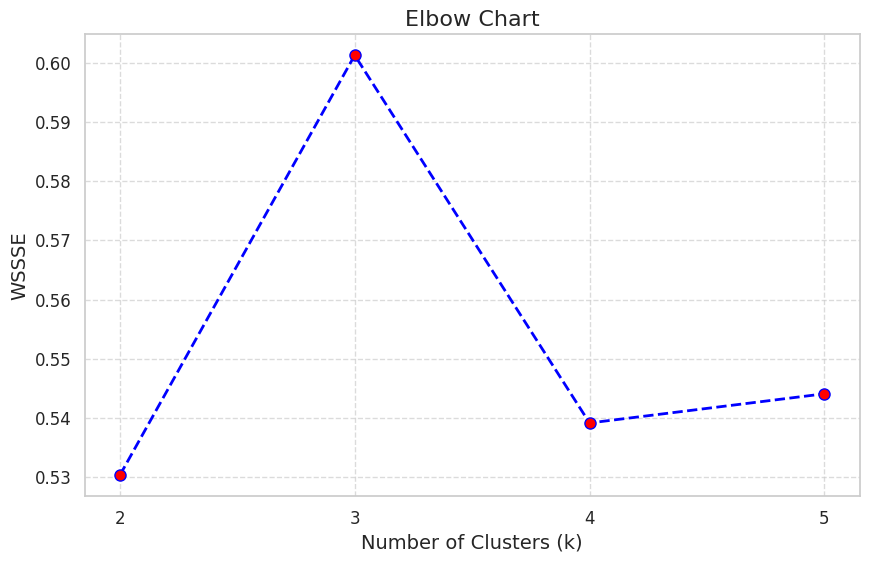

In [24]:
#Esta funcion grafica los wse para cada k
airbnb_clustering.plot_elbow_chart(k_values, wssse_list)

In [27]:
from sklearn.metrics import silhouette_score

#Esta funcion entrena, transforma y predice el modelo y luego con las predicciones calcula el silhouette

silhouette_scores = airbnb_clustering.calculate_silhouette_scores(data_with_features, k_values)

silhouette_scores

[0.38977107, 0.42822304, 0.40524748, 0.40662244]

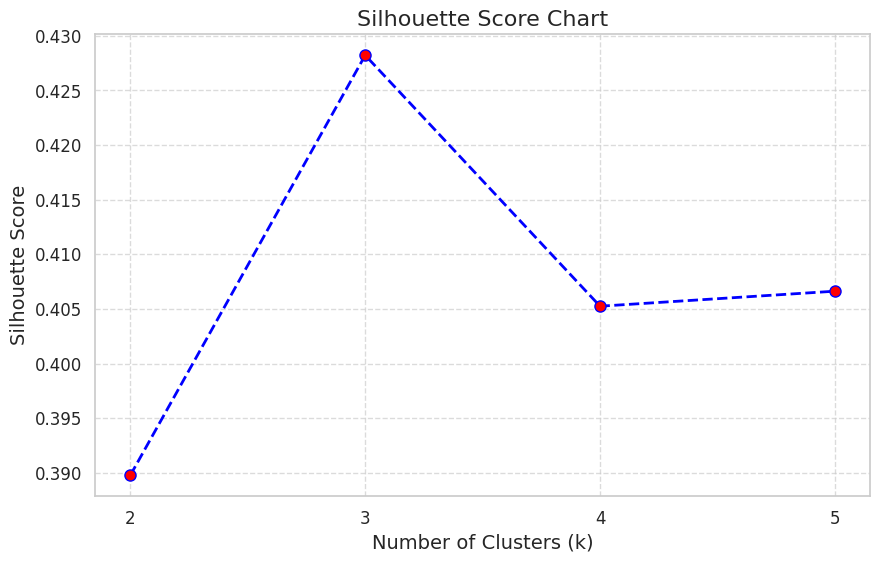

In [28]:
#Esta funcion grafica los silhouette para cada k

airbnb_clustering.plot_silhouette_score_chart(k_values, silhouette_scores)

**CLUSTERIZACION**

In [29]:
optimal_k = 3
#Esta funcion entrena el modelo
kmeans_model = airbnb_clustering.train_kmeans_model(data_with_features, optimal_k)

In [30]:
#Esta funcion predice el modelo
clustered_data = airbnb_clustering.assign_clusters(kmeans_model, data_with_features)
clustered_data.show()

+--------+---------+--------------------+----------+
|latitude|longitude|            features|prediction|
+--------+---------+--------------------+----------+
|40.64749|-73.97237|[40.6474914550781...|         0|
|40.75362|-73.98377|[40.7536201477050...|         1|
|40.80902| -73.9419|[40.8090209960937...|         1|
|40.68514|-73.95976|[40.6851387023925...|         0|
|40.79851|-73.94399|[40.7985115051269...|         1|
|40.74767|  -73.975|[40.7476692199707...|         1|
|40.68688|-73.95596|[40.6868782043457...|         0|
|40.76489|-73.98493|[40.7648887634277...|         1|
|40.80178|-73.96723|[40.8017807006835...|         1|
|40.71344|-73.99037|[40.7134399414062...|         0|
|40.80316|-73.96545|[40.8031616210937...|         1|
|40.76076|-73.98867|[40.7607612609863...|         1|
|40.66829|-73.98779|[40.6682891845703...|         0|
|40.79826|-73.96113|[40.7982597351074...|         1|
| 40.7353|-74.00525|[40.7352981567382...|         0|
|40.70837|-73.95352|[40.7083702087402...|     

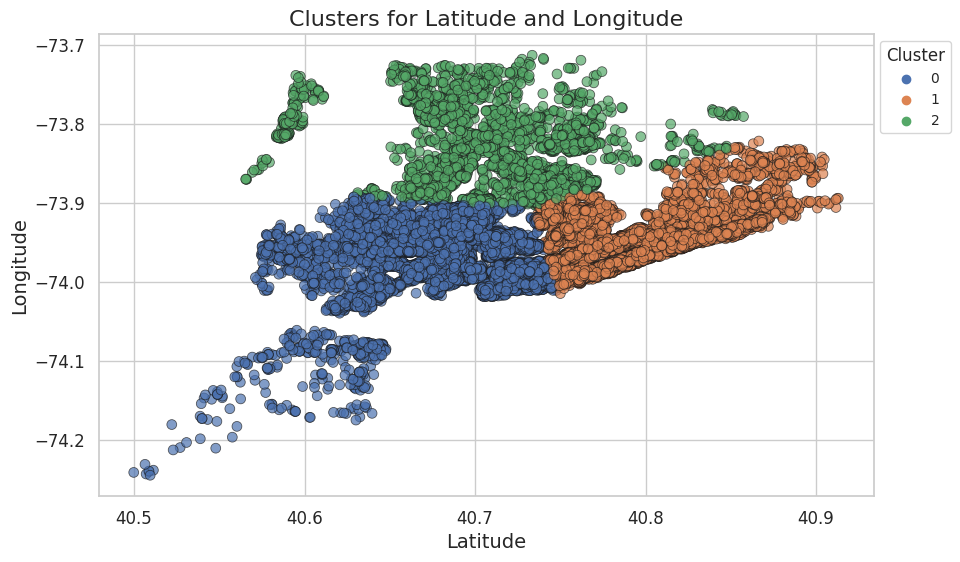

In [31]:
airbnb_clustering.visualize_clusters(clustered_data, "latitude", "longitude", "prediction")

In [32]:
airbnb_clustering.visualize_clusters_mapbox(clustered_data, "latitude", "longitude", "prediction", mapbox_access_token) #Agregar mapbox token

NameError: ignored